## Week 1 - Fixed Income Portfolios

### Internal Rate of Return

In [65]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
from datetime import datetime

In accordance with NEP 32, the function irr was removed from NumPy version 1.20.  A replacement for this function is available in the **numpy_financial** library: https://pypi.org/project/numpy-financial.  
To install numpy-financial --> pip install numpy_financial

In [2]:
cash_flow = [-100, 6, 6, 6, 6, 106]
irr = npf.irr(cash_flow)
print(f"The internal rate of return is {irr:.4f}")

The internal rate of return is 0.0600


### Present Value of Varying Cash Flow

In [27]:
cash_flow = [0, 8, 8, 8, 8, 108]
r = 0.08
npv = npf.npv(r, cash_flow)
print(f"The net present value is {npv:.2f}")

The net present value is 100.00


Note that npv should be 0 when the r equals to IRR. This small differenca could be caused by Python's floating-point arithmetic precision.

### Approximation Using Duration & Convexity

#### Computing Macualy Duration

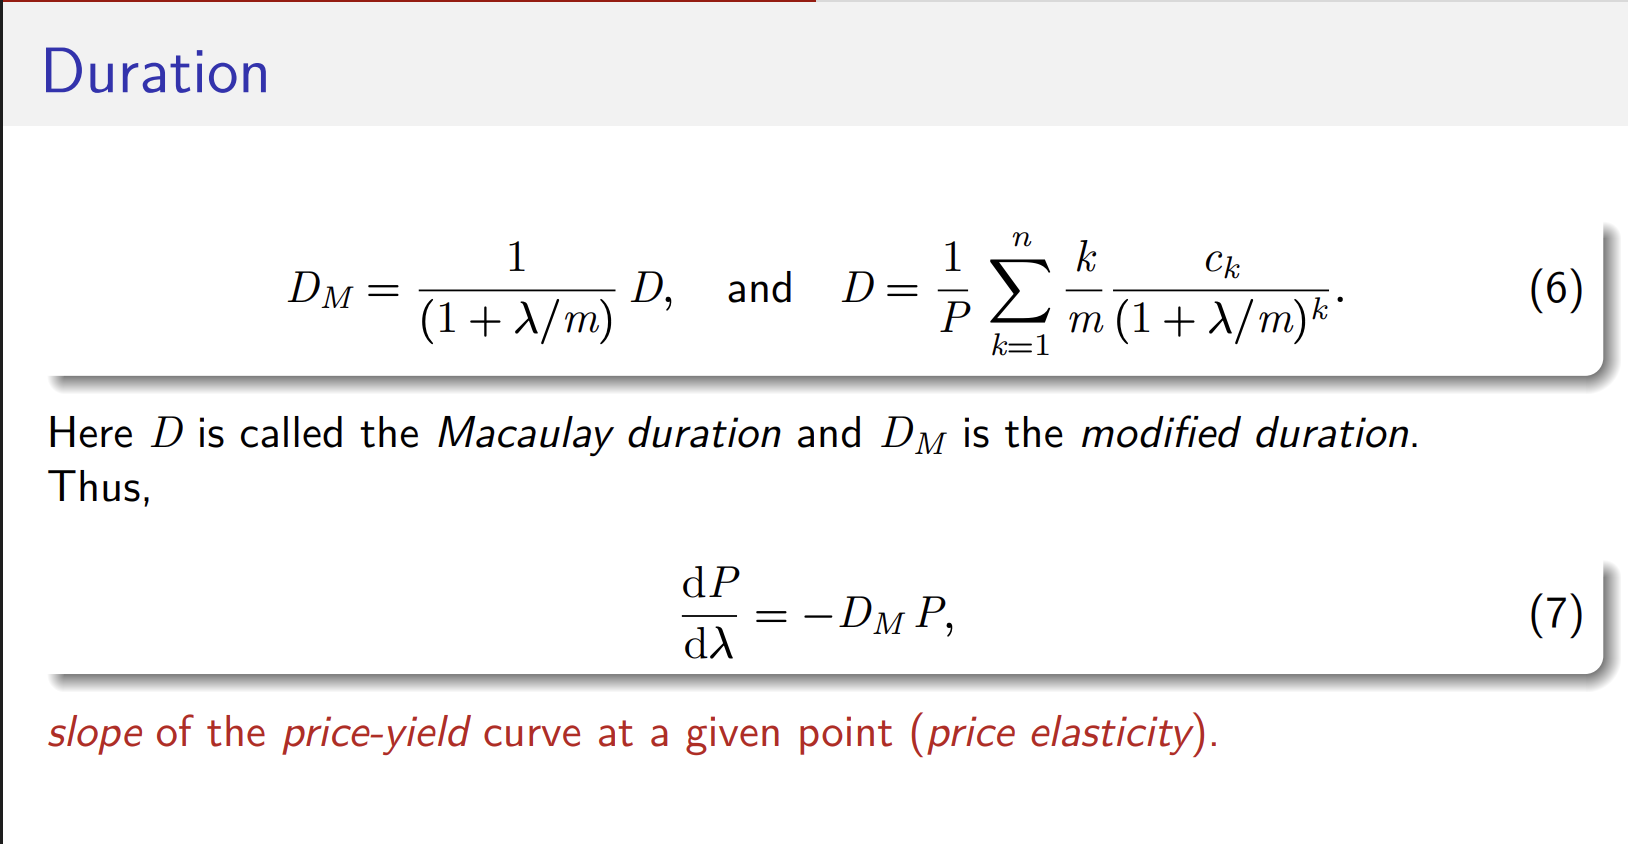

* Since we need an additional function that creates our cash flow from coupon rate and face value, we should define it first.

In [52]:
def create_cash_flow(face_value,coupon_rate, bond_length, freq=1):
    coupon_payment = face_value * coupon_rate / freq
    cash_flows = [coupon_payment] * (bond_length - 1) + [coupon_payment + face_value]
    cash_flows.insert(0, 0)
    return cash_flows

face_value = 100
coupon_rate = 0.10
periods = 3
cash_flow = create_cash_flow(face_value, coupon_rate, periods)
print("Cash Flows:", cash_flow)

Cash Flows: [0, 10.0, 10.0, 110.0]


In [63]:
def calculate_macualy_duration(yield_, face_value, coupon_rate, bond_length, freq=1):
    # i should start from 1 
    dur = 0
    cf = create_cash_flow(face_value, coupon_rate, bond_length)
    npv = npf.npv(yield_, cf)
    coupon_value = coupon_rate * face_value
    for i in range(1, bond_length+1):
        if i == bond_length:
            dur += ((coupon_value + face_value)*i)/((1+yield_)**i)
            continue 
        dur += ((coupon_value*i)/((1+yield_rate)**i))
    dur = (1/(1+yield_))*(dur/npv)
    return dur

yield_rate = 0.09
face_value = 100
coupon_rate = 0.10
macualy_duration = calculate_macualy_duration(yield_rate, face_value, coupon_rate, bond_length=3)

print(f"The Macaulay Duration is {macualy_duration:.4f} years")
        

The Macaulay Duration is 2.5128 years


#### Modified Duration

In [53]:
def calculate_modified_duration(macaulay_duration, yield_):
    mod_duration = macaulay_duration / (1 + yield_)
    return mod_duration

macualy_duration = 2.5128
yield_rate = 0.09

modified_duration = calculate_modified_duration(macualy_duration, yield_rate)
print(f"The Modified Duration is {modified_duration:.4f} years")

The Modified Duration is 2.3053 years


* Up until now, the primary goal has been to replicate the functionality of MATLAB's cfdur function (specifically, its Macaulay and Modified Duration calculations).

#### Calculating Convexity

In [56]:
def calculate_convexity(yield_, face_value, coupon_rate, bond_length, freq=1):
    conv = 0
    cf = create_cash_flow(face_value, coupon_rate, bond_length)
    npv = npf.npv(yield_, cf)
    coupon_value = coupon_rate * face_value
    for i in range(1, bond_length+1):
        if i == bond_length:
            conv += ((coupon_value + face_value)*i*(i+1))/((1+yield_/freq)**i)
            continue 
        conv += ((coupon_value*i*(i+1))/((1+yield_/freq)**i))
    conv = (1/(1+yield_)**2)*(conv/npv)
    return conv

yield_rate = 0.09
face_value = 100
coupon_rate = 0.10
convexity = calculate_convexity(yield_rate, face_value, coupon_rate, bond_length=3)
print(f"The Convexity is {convexity:.4f}")

The Convexity is 8.9325


#### Approximation

--- Reference Point (YTM = 0.05) ---
P0 (Exact Price): 117.7298
Macaulay Duration: 3.3618
Modified Duration: 3.2017
Convexity: 15.3091
------------------------------------------


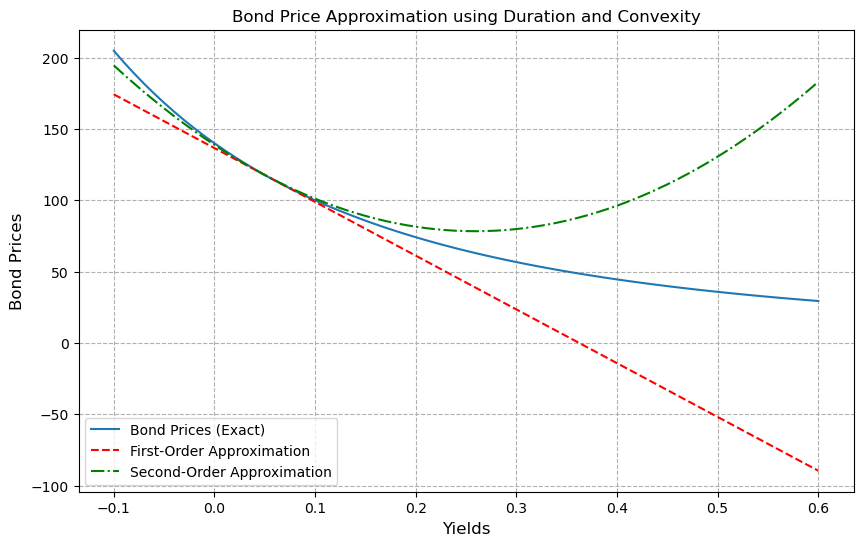

In [64]:
face_value = 100 
coupon_rate = 0.10 
bond_length = 4  
yield_rate = 0.05

cf = create_cash_flow(face_value, coupon_rate, bond_length)

yields = np.arange(-0.1, 0.61, 0.01)

prices = []
# Create a template cash flow *excluding* the initial -FV, just the future payments
# [10, 10, 10, 110]
for y in yields:
    # The PV is calculated from the future cash flows
    prices.append(npf.npv(y, cf)) # [0] is a placeholder for t=0

prices = np.array(prices)

# 3. Calculate Duration, Modified Duration, and Convexity at the reference point
P0 = npf.npv(yield_rate, cf) # Bond price at lambda0

duration = calculate_macualy_duration(yield_rate, face_value, coupon_rate, bond_length)
modified_duration = calculate_modified_duration(duration, yield_rate)
convexity = calculate_convexity(yield_rate, face_value, coupon_rate, bond_length)

print(f"--- Reference Point (YTM = {yield_rate:.2f}) ---")
print(f"P0 (Exact Price): {P0:.4f}")
print(f"Macaulay Duration: {duration:.4f}")
print(f"Modified Duration: {modified_duration:.4f}")
print(f"Convexity: {convexity:.4f}")
print("------------------------------------------")

# 4. First-order approximation (P_1)
P_1 = P0 * (1 - modified_duration * (yields - yield_rate))

# 5. Second-order approximation (P_2)
P_2 = P0 * (1 - modified_duration * (yields - yield_rate) 
            + 0.5 * convexity * (yields - yield_rate)**2)

# 6. Plotting
plt.figure(figsize=(10, 6))
plt.plot(yields, prices, label='Bond Prices (Exact)')
plt.plot(yields, P_1, 'r--', label='First-Order Approximation')
plt.plot(yields, P_2, 'g-.', label='Second-Order Approximation')

plt.title('Bond Price Approximation using Duration and Convexity')
plt.ylabel('Bond Prices', fontsize=12)
plt.xlabel('Yields', fontsize=12)
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

### Least-Squares Solution

* Matlab's **bnddury** function: 
 
[ModDuration,YearDuration,PerDuration] = bnddury(Yield,CouponRate,Settle,Maturity) computes the Macaulay and modified duration of NUMBONDS fixed income securities given yield to maturity for each bond.  

bnddury determines the Macaulay and modified duration for a bond whether the first or last coupon periods in the coupon structure are short or long (that is, whether the coupon structure is synchronized to maturity). bnddury also determines the Macaulay and modified duration for a zero coupon bond.

In our calculations, we need to define PerDuration which is :  
$$\text{PerDuration} = \text{Macualy Duration} \times \text{Frequency}$$

In [67]:
def calculate_periodic_duration(macualy_duration, freq):
    periodic_duration = macualy_duration * freq
    return periodic_duration

In [ ]:

settles = '02-09-2007'
maturities = ['03-10-2008', '04-11-2010', '31-12-2015']
coupon_rates = np.array([0.06, 0.07, 0.08])
yields = np.array([0.05, 0.075, 0.1])
face_value = 100 
freq = 1 


def calculate_time_to_maturity(settle_date_str, maturity_date_str, freq=1):
    settle = datetime.strptime(settle_date_str, '%d-%m-%Y') 
    maturity = datetime.strptime(maturity_date_str, '%d-%m-%Y')
    time_delta = maturity - settle
    T = time_delta.days / 365.25 
    periods = int(np.ceil(T * freq)) 
    return T, periods

T_list = []
N_list = []
for mat_date in maturities:
    T, N = calculate_time_to_maturity(settles, mat_date)
    T_list.append(T)
    N_list.append(N)

mac_durations = []
convexities = []

for y, r, N in zip(yields, coupon_rates, N_list):
    dur = calculate_macualy_duration(y, face_value, r, N, freq)
    conv = calculate_convexity(y, face_value, r, N, freq)
    mac_durations.append(dur)
    convexities.append(conv)


mac_durations = np.array(mac_durations)
convexities = np.array(convexities)

A = np.vstack([mac_durations, convexities, np.ones(3)])
b = np.array([10, 160, 1])

weights = np.linalg.solve(A, b)

# 4. Print Results
print(f"Durations: {mac_durations.round(4)}")
print(f"Convexities: {convexities.round(4)}")
print("\nCoefficient Matrix (A):")
print(A.round(4))
print("\nSolution")
print(f"Weights:\n{weights.round(4)}")

--- Bond Portfolio Immunization ---
Settle Date: 02-09-2007
Maturity Dates: ['03-10-2008', '04-11-2010', '31-12-2015']
Calculated Periods (N): [2, 4, 9]
Calculated Durations: [1.8513 3.3682 5.9913]
Calculated Convexities: [ 4.9892 14.0764 44.1128]

Coefficient Matrix (A):
[[ 1.8513  3.3682  5.9913]
 [ 4.9892 14.0764 44.1128]
 [ 1.      1.      1.    ]]

--- Solution ---
The Required Weights are:
[  8.45   -14.8647   7.4147]
Verification (A @ weights): [ 10. 160.   1.]
